# Open Exploration (Disaggregated Outcomes)

... [add NB description] ...

**Open Exploration Goals**

* 

**Notebook Outline**
1. [Model and Dependency Import](#1-model-and-dependency-import)  
2. [Dike Model Simulation](#2-dike-model-simulation)  
3. [Global Sensitivity Analysis](#3-global-sensitivity-analysis)  
4. [Scenario Discovery](#4-scenario-discovery)

## 1. Model and dependency import

In [1]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ema_workbench import (Scenario, Policy, MultiprocessingEvaluator, perform_experiments, ema_logging)
from ema_workbench import Samplers
from ema_workbench import save_results, load_results
from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

<Logger EMA (DEBUG)>

## 2. Dike Model Simulation

### 2.1 Sampling in the scenario (uncertainty) space: 20000 scenarios 1 policy

Systematically vary uncertain factors while keeping policy levers fixed, to analyze their impact on disaggregated outcomes (problem formulation 6).

In [24]:
######## Problem Formulation
pf = 6
n_scenario = 20000
n_policy = 1

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Policy (No Levers)
ref_policy = [Policy('policy 1', **{'0_RfR 0':0,
                                    '1_RfR 0':0,
                                    '2_RfR 0':0,
                                    '3_RfR 0':0,
                                    '4_RfR 0':0,
                                    '0_RfR 1':0,
                                    '1_RfR 1':0,
                                    '2_RfR 1':0,
                                    '3_RfR 1':0,
                                    '4_RfR 1':0,
                                    'A.1_DikeIncrease 0':0,
                                    'A.2_DikeIncrease 0':0,
                                    'A.3_DikeIncrease 0':0,
                                    'A.4_DikeIncrease 0':0,
                                    'A.5_DikeIncrease 0':0,
                                    'A.1_DikeIncrease 1':0,
                                    'A.2_DikeIncrease 1':0,
                                    'A.3_DikeIncrease 1':0,
                                    'A.4_DikeIncrease 1':0,
                                    'A.5_DikeIncrease 1':0,
                                    'EWS_DaysToThreat':0})
                                ]

######## Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenario, policies=ref_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 20000 scenarios * 1 policies * 1 model(s) = 20000 experiments
100%|████████████████████████████████████| 20000/20000 [06:47<00:00, 49.06it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S20000_P1_.tar.gz


### 2.2 Sampling in the policy (lever) space: 1 scenario 256 policy

Systematically vary policy levers while keeping the scenario (uncertainties) fixed, to analyze their impact on disaggregated outcomes (problem formulation 6).

In [3]:
######## Problem Formulation
pf = 6
n_scenario = 1
n_policy = 256

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Reference Scenario (Most Likely)
ref_dict = {'A.1_Bmax':170,
            'A.1_Brate':1.5,
            'A.1_pfail':0.5,
            'A.2_Bmax':170,
            'A.2_Brate':1.5,
            'A.2_pfail':0.5,
            'A.3_Bmax':170,
            'A.3_Brate':1.5,
            'A.3_pfail':0.5,
            'A.4_Bmax':170,
            'A.4_Brate':1.5,
            'A.4_pfail':0.5,
            'A.5_Bmax':170,
            'A.5_Brate':1.5,
            'A.5_pfail':0.5,
            'A.0_ID flood wave shape': 4,
            'discount rate 0': 3.5,
            'discount rate 1': 3.5,}

ref_scenario = [Scenario('reference', **ref_dict)]

######## Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=ref_scenario, policies=n_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 1 scenarios * 11264 policies * 1 model(s) = 11264 experiments
100%|████████████████████████████████████| 11264/11264 [05:01<00:00, 37.35it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S1_P256_.tar.gz


### 2.3 Sampling in scenario (uncertainty) and policy (lever) space: XX scenario XX policy

In [ ]:
######## Problem Formulation
pf = 6
n_scenario = 200  # reduced from 5000 to avoid MemoryError
n_policy = 2      # reduced from 256 to avoid MemoryError

######## Initialize Model
model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Run Model
ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes=6) as evaluator:
    results = evaluator.perform_experiments(scenarios=n_scenario, policies=n_policy, lever_sampling=Samplers.SOBOL)

save_results(results, 'results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))

[MainProcess/INFO] pool started with 6 workers
[MainProcess/INFO] performing 200 scenarios * 352 policies * 1 model(s) = 70400 experiments
 10%|███▊                                 | 7158/70400 [03:11<25:13, 41.79it/s]

## 3. Global Sensitivity Analysis

### 3.1 Feature Scoring of Scenario Space

In [9]:
######## Problem Formulation
pf, n_scenario, n_policy = 6, 20000, 1 

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Load results
results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))
experiments, outcomes = results

######## drop levers
experiments.drop(columns=list(model.levers.keys()), inplace=True)

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S20000_P1_.tar.gz


In [10]:
experiments.head()

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,scenario,policy,model
0,15,104.951766,1.5,0.866037,72.423761,1.5,0.784919,260.727340,1.0,0.427487,...,10.0,0.746491,329.289172,1.0,0.326723,4.5,1.5,26264,policy 1,dikesnet
1,27,268.758784,1.0,0.439213,179.347355,10.0,0.250512,98.160975,1.0,0.125769,...,1.5,0.920575,224.384026,10.0,0.931482,4.5,1.5,26265,policy 1,dikesnet
2,120,274.597925,10.0,0.752513,174.253795,1.5,0.358975,219.550772,10.0,0.254221,...,1.0,0.564166,66.633747,10.0,0.731416,3.5,4.5,26266,policy 1,dikesnet
3,51,229.349571,10.0,0.308457,76.893599,10.0,0.470869,223.435463,10.0,0.801025,...,10.0,0.340353,177.164724,10.0,0.544277,2.5,4.5,26267,policy 1,dikesnet
4,10,302.133282,1.0,0.202844,255.568891,10.0,0.264802,326.750685,10.0,0.798309,...,10.0,0.937984,200.450219,1.5,0.543679,1.5,2.5,26268,policy 1,dikesnet


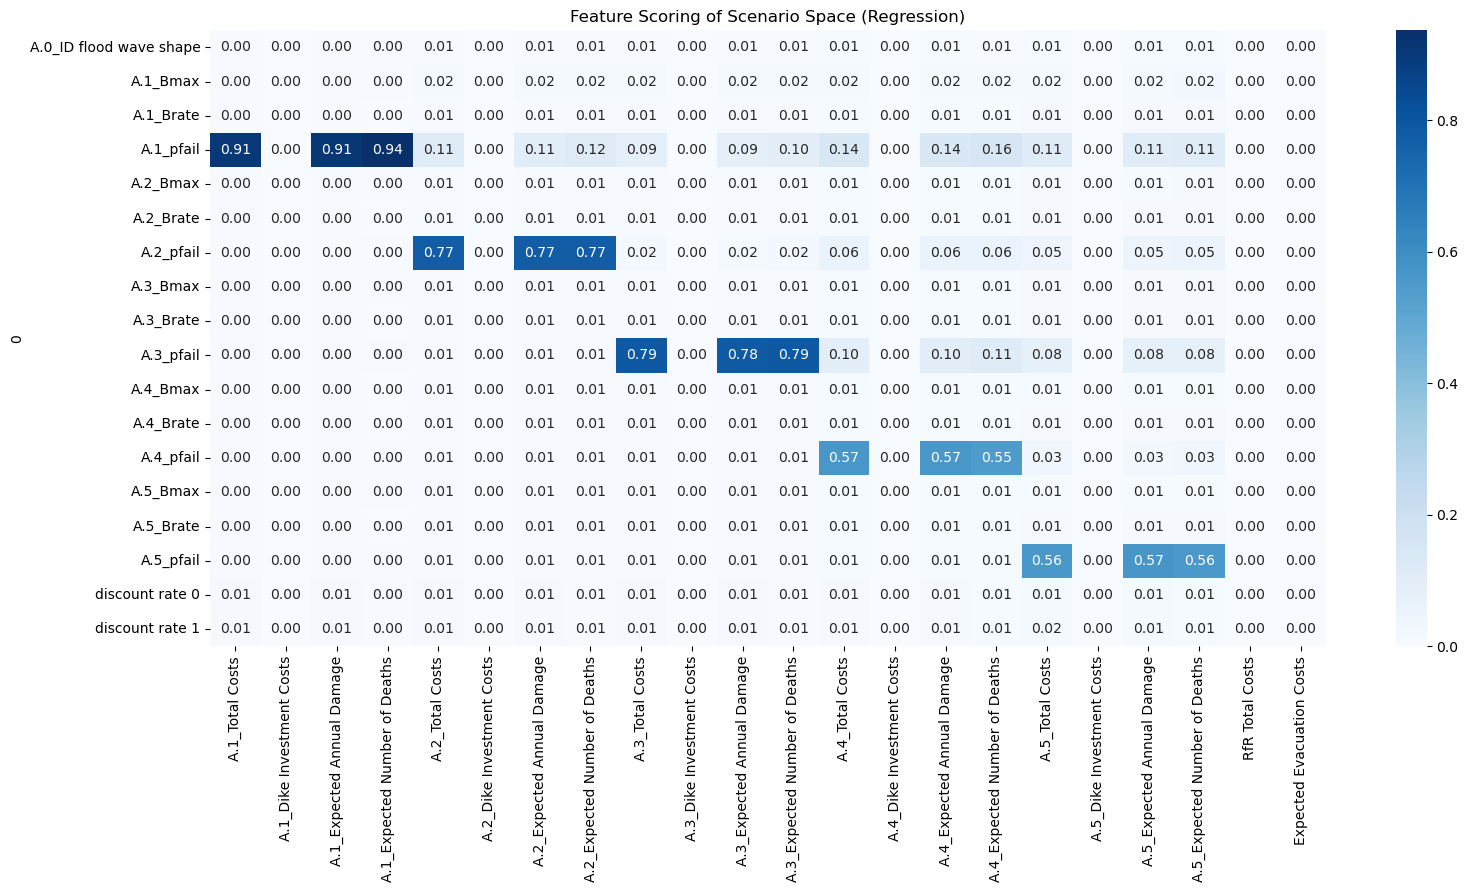

In [13]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
plt.figure(figsize=(18, 8))
ax = sns.heatmap(scores, annot=True, cmap = "Blues", fmt=".2f")
ax.set_title("Feature Scoring of Scenario Space (Regression)")
plt.show()

### 3.2 Feature Scoring of Policy Space

In [14]:
######## Problem Formulation
pf, n_scenario, n_policy = 6, 1, 256

model, steps = get_model_for_problem_formulation(pf)
uncertainties = model.uncertainties
levers = model.levers

######## Load results
results = load_results('results/data/GSA_PF{}_S{}_P{}_.tar.gz'.format(pf, n_scenario, n_policy))
experiments, outcomes = results

######## drop uncertainties
experiments.drop(columns=list(model.uncertainties.keys())+['policy'], inplace=True)

[MainProcess/INFO] results loaded successfully from d:\GitHub\epa141a-flood-policy-optimization-overijssel\final assignment\results\data\GSA_PF6_S1_P256_.tar.gz


In [6]:
experiments.head()

,0_RfR 0,0_RfR 1,1_RfR 0,1_RfR 1,2_RfR 0,2_RfR 1,3_RfR 0,3_RfR 1,4_RfR 0,4_RfR 1,...,A.2_DikeIncrease 1,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.5_DikeIncrease 0,A.5_DikeIncrease 1,EWS_DaysToThreat,scenario,model
0,1,0,0,0,0,0,0,0,0,1,...,7,3,0,1,7,7,1,3,reference,dikesnet
1,1,0,0,0,0,0,0,0,0,1,...,7,3,0,1,7,7,1,3,reference,dikesnet
2,1,1,0,0,0,0,0,0,0,1,...,7,3,0,1,7,7,1,3,reference,dikesnet
3,1,0,1,0,0,0,0,0,0,1,...,7,3,0,1,7,7,1,3,reference,dikesnet
4,1,0,0,0,0,0,0,0,0,1,...,7,3,0,1,7,7,1,3,reference,dikesnet


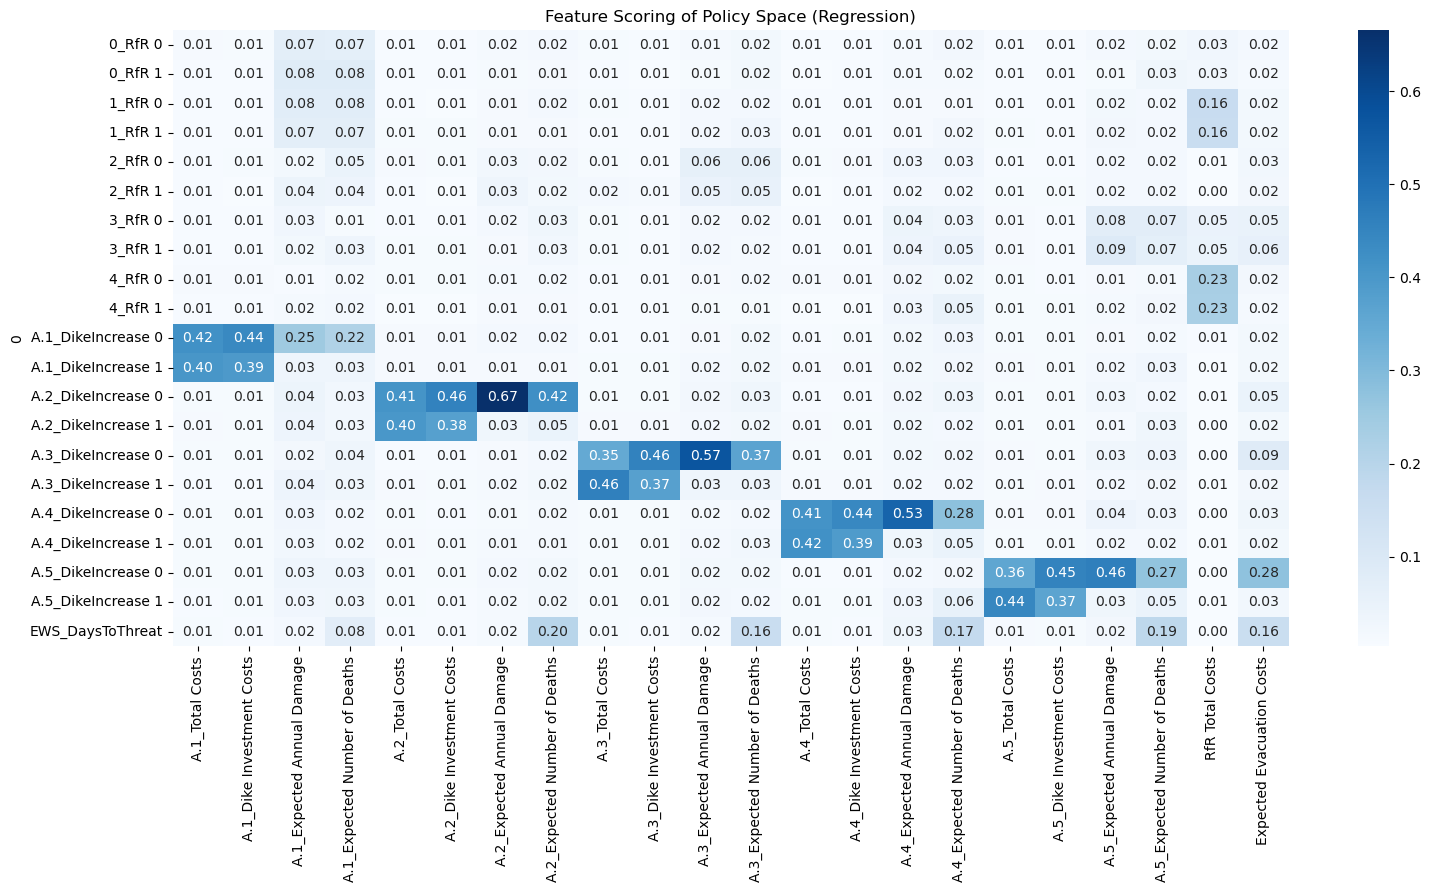

In [15]:
import matplotlib.pyplot as plt

scores = feature_scoring.get_feature_scores_all(experiments, outcomes, mode=RuleInductionType.REGRESSION)
plt.figure(figsize=(18, 8))
ax = sns.heatmap(scores, annot=True, cmap="Blues", fmt=".2f")
ax.set_title("Feature Scoring of Policy Space (Regression)")
plt.show()

## 4. Scenario Discovery

#### TO IMPROVE THE OPEN EXPLORATION
1. test policies with more reference scenarios